### Post-Variational QML ( Pennylane )

Reference :
Xanadu. (n.d.). Post-variational quantum neural networks. PennyLane. Retrieved [date], from https://pennylane.ai/qml/demos/tutorial_post-variational_quantum_neural_networks


## Introduction _ why post-variational qml?

many ansatz in the variational strategy face **the barren plateau problem**,  which leads to difficulty in convergence using gradient-based optimization techniques. Due to the general difficulty and lack of training guarantees of variational algorithms, here we will develop an alternative training strategy that does not involve tuning the quantum circuit parameters

#### Import libraries and datasets from sklearn

In [3]:
import pennylane as qml
from pennylane import numpy as np
import jax
from jax import numpy as jnp
import optax
from itertools import combinations
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import matplotlib.colors
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)


In [4]:
# Load the digits dataset with features (X_digits) and labels (y_digits)
X_digits, y_digits = load_digits(return_X_y=True)


# Create a boolean mask array of the same length as the labels
# np.isin returns True or False based on whether the label is in the specified list [2,6]
filter_mask = np.isin(y_digits, [2, 6])


# Example of the mask to the feature and label arrays
# arr = [1,2,3,4,5,6]
# mask = [True, False, True, False, True, False]
# print(np.array(arr)[mask])


# Apply the filter mask to the features and labels to keep only the selected digits
# filter_mask is the array that contains True for the indices that are 2 or 6
X_digits = X_digits[filter_mask]
y_digits = y_digits[filter_mask]


# Split the filtered dataset into training and testing sets with 10% of data reserved for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, test_size=0.1, random_state=42
)

# Normalize the pixel values in the training and testing data
# Convert each image from a 1D array to an 8x8 2D array, normalize pixel values, and scale them
'''
Reshape: Each image in X_train and X_test is originally a 1D array. The code reshapes each image into an 8x8 2D array.
Normalize: The pixel values are divided by 16 to normalize them. This scales the pixel values to a range of 0 to 1.
Scale: The normalized pixel values are then scaled by multiplying by (2 \pi). 
This scales the values to a range of 0 to (2 \pi), which is useful for certain types of neural networks, 
especially those involving trigonometric functions.
'''
X_train = np.array([item.reshape([8, 8]) / 16 * 2 * np.pi for item in X_train])
X_test = np.array([item.reshape([8, 8]) / 16 * 2 * np.pi for item in X_test])

# Adjust the labels to be centered around 0 and scaled to be in the range -1 to 1
# The original labels (2 and 6) are mapped to -1 and 1 respectively
y_train = (y_train - 4) / 2
y_test = (y_test - 4) / 2


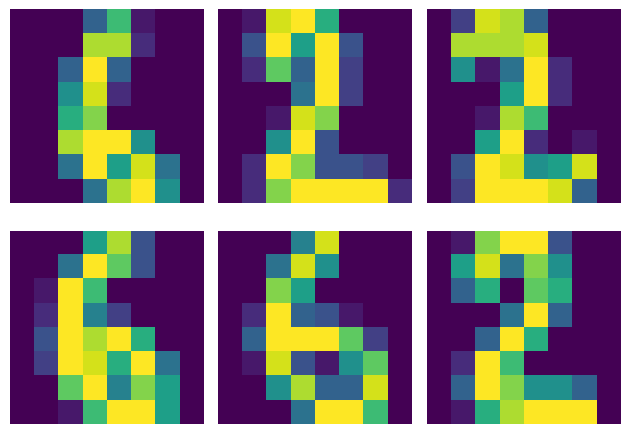

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, layout="constrained")


# Display 6 images in the training set
for i in range(2):
    for j in range(3):
      axes[i][j].matshow(X_train[2*(2*j+i)])
      axes[i][j].axis('off')
fig.subplots_adjust(hspace=0.0)
fig.tight_layout()
plt.show()


#### define Feature Map and Anasatz

In [ ]:
# feaures : 8 x 8 pixel tensor

def feature_map(features):

    # apply H gates for superposition
    for i in range(len(features[0])):
        qml.Hadamard(i)
    
    for i in range(len(features)):

        # apply RZ, RX gates for each pixel
        # a
        if i % 2 == 1:
            qml.AngleEmbedding(features[i], wires=range(len(features[0])), rotation='Z')  # even number of pixel row
        
        else:
            qml.AngleEmbedding(features[i], wires=range(len(features[0])) , rotation='X') # odd number of pixel row
        

def ansatz(params):

    # Ry rotations with the 1st set of param
    for i in range(8):
        qml.RY(params[i], wires=i)
    
    # CNOTs cyclically connected ( entanglement )
    for i in range(8):
        qml.CNOT(wires=[ (i-1)%8, i%8 ])  # (7,0), (0,1), (1,2), ... (6,7)

    # RY rotations with the 2nd set of param
    for i in range(8):
        qml.RY(params[i+8], wires=i)

    
    # CNOTs cyclically connected ( entanglement + reverse order )
    for i in range(8):
        qml.CNOT(wires=[(8 - 2 - i) % 8, (8 - i - 1) % 8])  # (6,7), (5,6), (4,5), ... (1,0)


#### choose device ( simulator )

What does this decorator do?
```python
@qml.qnode(dev)  
def circuit(params, features):
    ...
```

decorator = wrap-up function

moves circuit fun  -> to -> qml.qnode(dev) function for converting circuit to QNode

<br>

__Transforms the Function__: It converts the circuit function into a QNode, which is a special type of function that can be executed on a quantum device.
<br>

__Manages Quantum Device Execution__: The decorator ensures that the quantum operations defined within the circuit function are executed on the specified quantum device (dev).
<br>

__Handles Quantum State and Measurements__: It manages the quantum state preparation, execution of quantum gates, and measurement of expectation values.

In [ ]:
dev = qml.device("default.qubit", wires=8) # statevector simulator in pennylane

@qml.qnode(dev) # move the quantum circuit to the device
def circuit(weights_param, features):

    feature_map(features) # encode features to quantum state
    ansatz(weights_param) # apply the ansatz with the weights

    return qml.expval(qml.PauliZ(0)) # measurement of the 1st qubit with PauliZ 

def variational_classifier(weights, bias, x):
    return circuit(weights, features=x) + bias   # return the output of the circuit + bias = expval(PauliZ) + bias

def square_loss(labels, predictions):
    return np.mean( (labels - qml.math.stack(predictions)) ** 2 )

def accuracy(labels, predictions):
    acc = sum([np.sign(l) == np.sign(p) for l, p in zip(labels, predictions)])
    acc = acc / len(labels)
    return acc


def cost(params, X, Y):
    predictions = [variational_classifier(params["weights"], params["bias"], x) for x in X]
    return square_loss(Y, predictions)


def acc(params, X, Y):
    predictions = [variational_classifier(params["weights"], params["bias"], x) for x in X]
    return accuracy(Y, predictions)


np.random.seed(0)

# Initialize the weights, bias, and parameters
weights = 0.01 * np.random.randn(16)
bias = jnp.array(0.0)
params = {"weights": weights, "bias": bias}

# Initialize the optimizer
opt = optax.adam(0.05)

# Batch the data
batch_size = 7
num_batch = X_train.shape[0] // batch_size
opt_state = opt.init(params)
X_batched = X_train.reshape([-1, batch_size, 8, 8])
y_batched = y_train.reshape([-1, batch_size])


@jax.jit
def update_step_jit(i, args):
    params, opt_state, data, targets, batch_no = args
    _data = data[batch_no % num_batch]
    _targets = targets[batch_no % num_batch]
    _, grads = jax.value_and_grad(cost)(params, _data, _targets)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state, data, targets, batch_no + 1)


@jax.jit
def optimization_jit(params, data, targets):
    opt_state = opt.init(params)
    args = (params, opt_state, data, targets, 0)
    (params, opt_state, _, _, _) = jax.lax.fori_loop(0, 200, update_step_jit, args)
    return params


params = optimization_jit(params, X_batched, y_batched)
var_train_acc = acc(params, X_train, y_train)
var_test_acc = acc(params, X_test, y_test)

print("Training accuracy: ", var_train_acc)
print("Testing accuracy: ", var_test_acc)
